In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import kagglehub
import PIL
import tqdm as tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,ConcatDataset
import torch.optim as optim
from torchvision import transforms, models,datasets
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [32]:
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images") 
print("Path to dataset files:", path)

Path to dataset files: /home/dc_gr1/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [33]:
import shutil

src_root = os.path.join(path, "lung_colon_image_set")
merged_root = os.path.join(path, "merged_5class")

os.makedirs(merged_root, exist_ok=True)

for main_folder in os.listdir(src_root):
    main_path = os.path.join(src_root, main_folder)
    if not os.path.isdir(main_path):
        continue

    for sub_folder in os.listdir(main_path):
        src_folder = os.path.join(main_path, sub_folder)
        if not os.path.isdir(src_folder):
            continue

        new_folder_name = sub_folder
        dst_folder = os.path.join(merged_root, new_folder_name)
        os.makedirs(dst_folder, exist_ok=True)

        for img_name in os.listdir(src_folder):
            src_img = os.path.join(src_folder, img_name)
            dst_img = os.path.join(dst_folder, img_name)
            shutil.copy2(src_img, dst_img)

        print(f"✅ Merged {sub_folder} into {dst_folder}")

print("All 5 folders combined inside:", merged_root)

✅ Merged colon_aca into /home/dc_gr1/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/merged_5class/colon_aca
✅ Merged colon_n into /home/dc_gr1/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/merged_5class/colon_n
✅ Merged lung_aca into /home/dc_gr1/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/merged_5class/lung_aca
✅ Merged lung_n into /home/dc_gr1/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/merged_5class/lung_n
✅ Merged lung_scc into /home/dc_gr1/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/merged_5class/lung_scc
All 5 folders combined inside: /home/dc_gr1/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/merged_5class


In [34]:
dataset_root = os.path.join(path, "merged_5class")

In [35]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=dataset_root, transform=transform)

print(" Classes detected:", full_dataset.classes)
print(" Total images:", len(full_dataset))

 Classes detected: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
 Total images: 25000


All detected classes (subclasses): ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


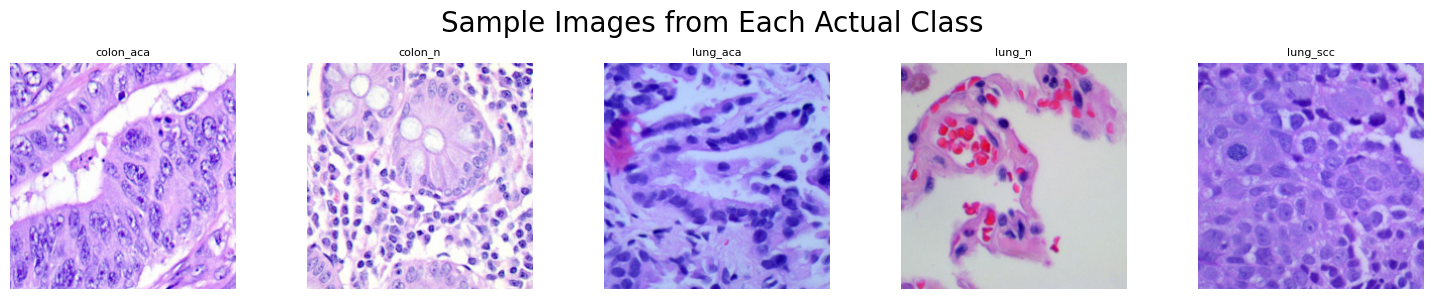

In [40]:
import random
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=8)
    plt.axis('off')

all_classes = full_dataset.classes
print("All detected classes (subclasses):", all_classes)

plt.figure(figsize=(15, 3))

for i, cls in enumerate(all_classes):
    indices = [idx for idx, (_, label) in enumerate(full_dataset.samples) if label == i]
    sample_idx = random.choice(indices)
    img, label = full_dataset[sample_idx]

    plt.subplot(int(np.ceil(len(all_classes) / 5)), 5, i + 1)
    imshow(img, title=cls)

plt.suptitle("Sample Images from Each Actual Class ", fontsize=20)
plt.tight_layout()
plt.show()


In [41]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

targets = [full_dataset[i][1] for i in range(len(full_dataset))]
targets = np.array(targets)

train_idx, temp_idx = train_test_split( np.arange(len(full_dataset)),test_size=0.30,stratify=targets,random_state=42)

temp_targets = targets[temp_idx]
val_idx, test_idx = train_test_split(temp_idx,test_size=0.50,stratify=temp_targets,random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 17500
Validation samples: 3750
Test samples: 3750


In [42]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

def make_layer(in_channels, out_channels, num_blocks, stride):
    layers = []
    layers.append(ResidualBlock(in_channels, out_channels, stride))
    for _ in range(1, num_blocks):
        layers.append(ResidualBlock(out_channels, out_channels))
    return nn.Sequential(*layers)

class DeepResidualCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(DeepResidualCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer2 = make_layer(64, 128, num_blocks=3, stride=2)
        self.layer3 = make_layer(128, 256, num_blocks=4, stride=2)
        self.layer4 = make_layer(256, 512, num_blocks=6, stride=2)
        self.layer5 = make_layer(512, 512, num_blocks=3, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = DeepResidualCNN(num_classes=5)
print(model)


DeepResidualCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [44]:
device

device(type='cuda')

In [46]:
from collections import Counter

def get_split_class_distribution(split_dataset):
    labels = [label for _, label in split_dataset]
    return Counter(labels)

print("Train class distribution:", get_split_class_distribution(train_dataset))
print("Val class distribution:", get_split_class_distribution(val_dataset))
print("Test class distribution:", get_split_class_distribution(test_dataset))


Train class distribution: Counter({0: 3500, 3: 3500, 2: 3500, 4: 3500, 1: 3500})
Val class distribution: Counter({0: 750, 1: 750, 4: 750, 2: 750, 3: 750})
Test class distribution: Counter({0: 750, 1: 750, 4: 750, 2: 750, 3: 750})


In [48]:
import torch
import copy

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, save_path='best_model.pth'):
    train_losses, val_losses = [], []
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f" Best model saved at epoch {epoch+1} with Val Acc: {val_acc:.2f}%")

    model.load_state_dict(best_model_wts)
    print(f"\n Training complete. Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f" Best model saved to '{save_path}'")

    return model, train_losses, val_losses


model, train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch [1/10] | Train Loss: 0.1562 | Val Loss: 0.1006 | Val Acc: 96.53%
 Best model saved at epoch 1 with Val Acc: 96.53%
Epoch [2/10] | Train Loss: 0.1192 | Val Loss: 0.0962 | Val Acc: 96.00%
Epoch [3/10] | Train Loss: 0.0931 | Val Loss: 0.0766 | Val Acc: 96.99%
 Best model saved at epoch 3 with Val Acc: 96.99%
Epoch [4/10] | Train Loss: 0.0757 | Val Loss: 0.0612 | Val Acc: 97.65%
 Best model saved at epoch 4 with Val Acc: 97.65%
Epoch [5/10] | Train Loss: 0.0811 | Val Loss: 0.0516 | Val Acc: 97.92%
 Best model saved at epoch 5 with Val Acc: 97.92%
Epoch [6/10] | Train Loss: 0.0554 | Val Loss: 0.0472 | Val Acc: 98.24%
 Best model saved at epoch 6 with Val Acc: 98.24%
Epoch [7/10] | Train Loss: 0.0478 | Val Loss: 0.0278 | Val Acc: 98.96%
 Best model saved at epoch 7 with Val Acc: 98.96%
Epoch [8/10] | Train Loss: 0.0451 | Val Loss: 0.0348 | Val Acc: 98.53%
Epoch [9/10] | Train Loss: 0.0309 | Val Loss: 0.8770 | Val Acc: 82.88%
Epoch [10/10] | Train Loss: 0.0335 | Val Loss: 0.0303 | Val A

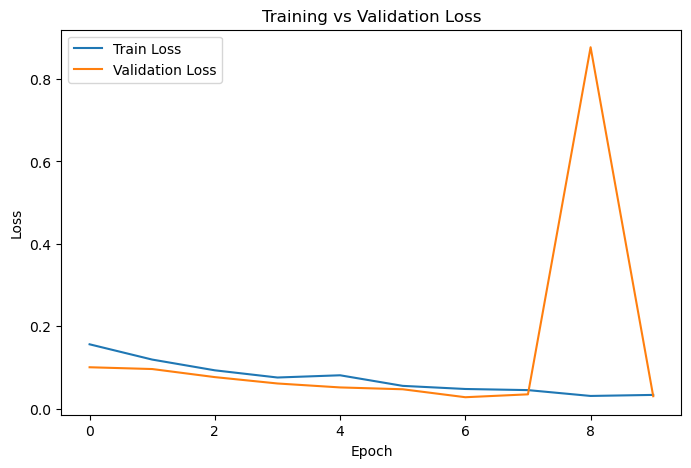

In [49]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [50]:
def evaluate_model(model, test_loader, all_class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = np.mean(all_preds == all_labels) * 100
    print(f"Test Accuracy: {acc:.2f}%\n")

    unique_labels = np.unique(all_labels)
    target_names = [all_class_names[i] for i in unique_labels]

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    cm = confusion_matrix(all_labels, all_preds)
    return cm, all_labels, all_preds


class_names = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

cm, y_true, y_pred = evaluate_model(model, test_loader, class_names)

Test Accuracy: 99.04%

Classification Report:
              precision    recall  f1-score   support

   colon_aca       1.00      0.99      0.99       750
     colon_n       0.99      1.00      0.99       750
    lung_aca       0.97      0.99      0.98       750
      lung_n       1.00      1.00      1.00       750
    lung_scc       0.99      0.97      0.98       750

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750



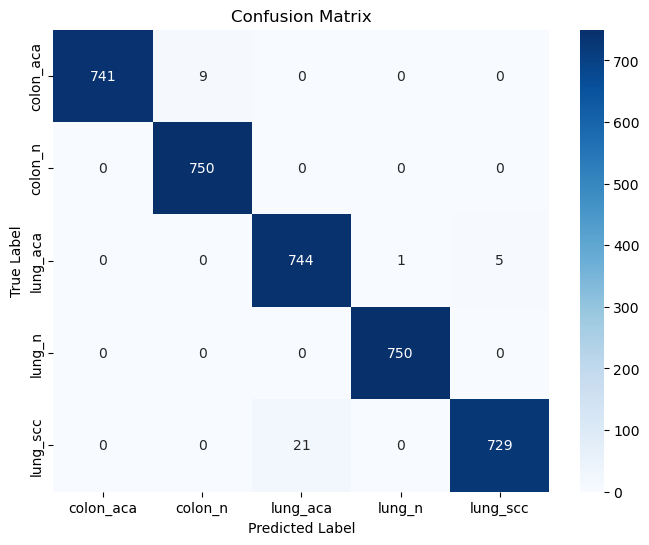

In [51]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"],
            yticklabels=["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

/tmp/ipykernel_33150/149243013.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


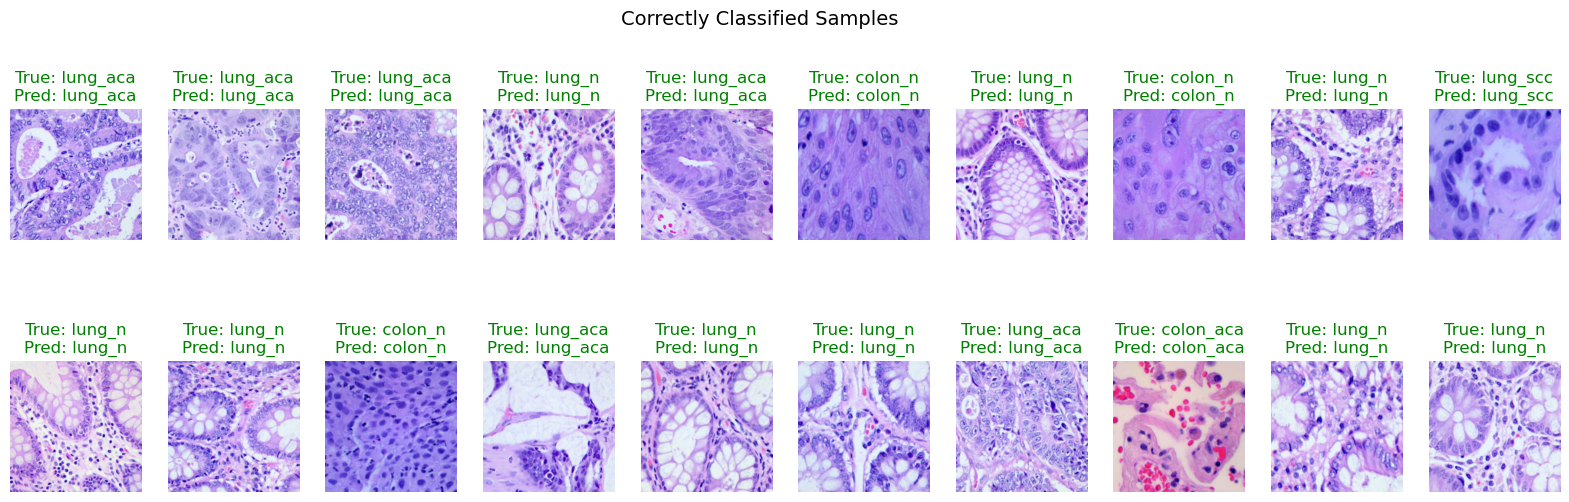

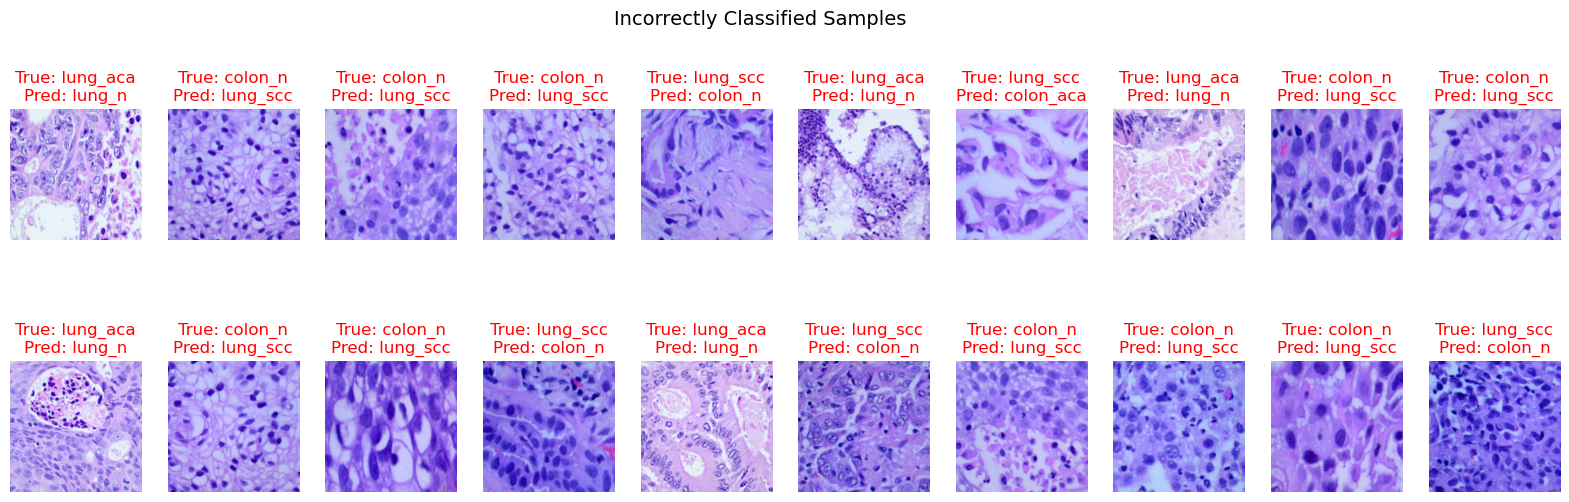

In [65]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

class_names = ['lung_aca', 'lung_n', 'lung_scc', 'colon_aca', 'colon_n']

correct_samples = []
incorrect_samples = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for img, label, pred in zip(images, labels, preds):
            if len(correct_samples) < 20 and pred == label:
                correct_samples.append((img.cpu(), label.item(), pred.item()))
            elif len(incorrect_samples) < 20 and pred != label:
                incorrect_samples.append((img.cpu(), label.item(), pred.item()))

        if len(correct_samples) >= 20 and len(incorrect_samples) >= 20:
            break

def imshow(img, label, pred, title_color="black"):
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(f"True: {class_names[label]}\nPred: {class_names[pred]}", color=title_color)
    plt.axis('off')

# Show correct predictions
plt.figure(figsize=(20, 6))
for i, (img, label, pred) in enumerate(correct_samples):
    plt.subplot(2, 10, i + 1)
    imshow(img, label, pred, "green")
plt.suptitle("Correctly Classified Samples", fontsize=14)
plt.show()

# Show incorrect predictions
plt.figure(figsize=(20, 6))
for i, (img, label, pred) in enumerate(incorrect_samples):
    plt.subplot(2, 10, i + 1)
    imshow(img, label, pred, "red")
plt.suptitle("Incorrectly Classified Samples", fontsize=14)
plt.show()


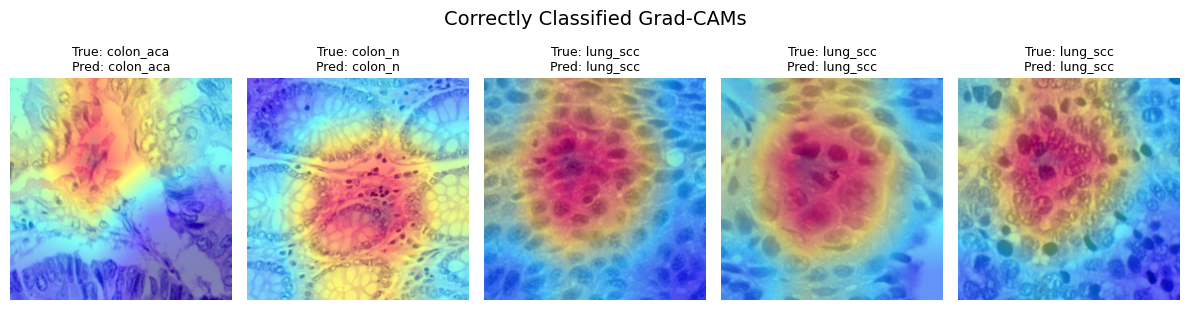

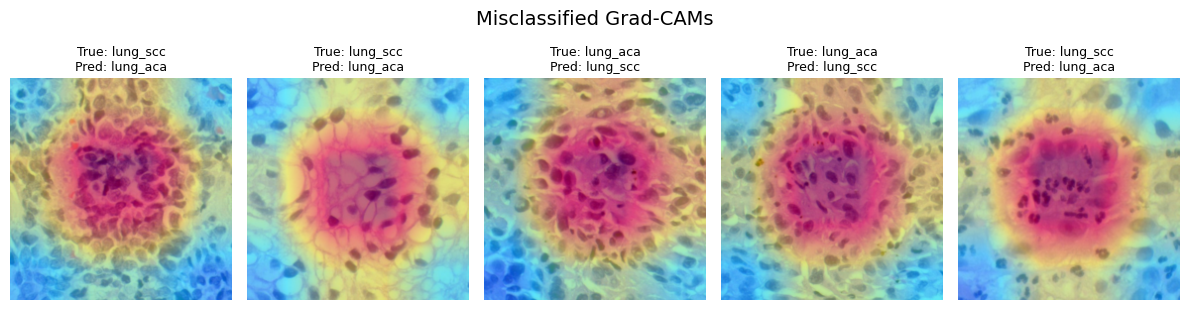

In [80]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

# ---- Grad-CAM Hook Functions ----
def get_features_hook(module, input, output):
    global features
    features = output

def get_gradients_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# ---- Grad-CAM Function ----
def generate_gradcam(model, img_tensor, class_idx):
    model.zero_grad()
    img_tensor = img_tensor.unsqueeze(0).to(device)
    img_tensor.requires_grad_(True)

    output = model(img_tensor)
    target = output[0, class_idx]
    target.backward()

    pooled_grads = torch.mean(gradients, dim=[0, 2, 3])
    gradcam = torch.mean(features * pooled_grads[None, :, None, None], dim=1).squeeze()

    gradcam = np.maximum(gradcam.detach().cpu().numpy(), 0)
    gradcam = cv2.resize(gradcam, (224, 224))
    gradcam = gradcam / gradcam.max()
    return gradcam

# ---- Register hooks on last conv layer ----
target_layer = model.layer5[-1].conv2
target_layer.register_forward_hook(get_features_hook)
target_layer.register_backward_hook(get_gradients_hook)


# ---- Inverse Normalization ----
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

model.eval()
classes = full_dataset.classes
correct_samples, incorrect_samples = [], []

# ⚠️ DO NOT USE torch.no_grad() HERE (we need gradients)
for i, (img, label) in enumerate(val_loader):
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

    for j in range(img.size(0)):
        if preds[j] == label[j]:
            correct_samples.append((img[j].cpu(), label[j].item(), preds[j].item()))
        else:
            incorrect_samples.append((img[j].cpu(), label[j].item(), preds[j].item()))

    if len(correct_samples) >= 5 and len(incorrect_samples) >= 5:
        break

# ---- Display Grad-CAM ----
def show_gradcam_samples(samples, title):
    plt.figure(figsize=(12, 6))
    for i, (img, true_label, pred_label) in enumerate(samples[:5]):
        gradcam = generate_gradcam(model, img.to(device), pred_label)
        img_np = inv_normalize(img).numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)

        heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = np.float32(heatmap) / 255 + np.float32(img_np)
        overlay = overlay / np.max(overlay)

        plt.subplot(2, 5, i + 1)
        plt.imshow(overlay)
        plt.title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

show_gradcam_samples(correct_samples, "Correctly Classified Grad-CAMs")
show_gradcam_samples(incorrect_samples, "Misclassified Grad-CAMs")
